# Analyzing Stock Market Correlations with Graph Theory 📈

This notebook demonstrates how to build a network graph to visualize the correlation between different stocks. The process involves:
1.  **Fetching Data**: Downloading the last two years of daily stock prices for a list of companies using the `yfinance` library.
2.  **Calculating Returns**: Computing the daily logarithmic returns for each stock.
3.  **Correlation Analysis**: Creating a correlation matrix from the log returns.
4.  **Building the Graph**: Constructing a network where stocks are nodes and an edge exists if their correlation exceeds a set threshold.
5.  **Visualization**: Plotting the resulting network to visually identify clusters of related stocks.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## 1. Data Fetching and Preparation

First, we define our list of stock tickers and a two-year period for our analysis. We then use `yfinance` to download the daily closing prices for all tickers at once.

In [2]:
# Define the list of stock tickers
tickers = ['TSLA', 'AMZN', 'AMD', 'AAPL', 'CSCO', 'NFLX', 'QCOM', 'SBUX', 'META']

# Set the time period for the last two years
end_date = datetime.now()
start_date = end_date - timedelta(days=2*365)

# Download the closing price data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)
close_prices = data['Close']

# Remove any rows with missing price data
close_prices = close_prices.dropna()

print("Successfully downloaded and prepared the closing prices:")
print(close_prices.head())

/tmp/ipykernel_115125/60488970.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  9 of 9 completed

Successfully downloaded and prepared the closing prices:
Ticker            AAPL         AMD        AMZN       CSCO        META  \
Date                                                                    
2023-10-06  175.768372  107.239998  127.959999  50.463676  313.497375   
2023-10-09  177.253815  106.970001  128.259995  50.907406  316.409393   
2023-10-10  176.659622  109.010002  129.479996  50.860207  319.868103   
2023-10-11  178.055954  108.309998  131.830002  50.661934  325.811493   
2023-10-12  178.957138  108.790001  132.330002  50.841320  322.173859   

Ticker            NFLX        QCOM       SBUX        TSLA  
Date                                                       
2023-10-06  381.510010  106.222862  88.301056  260.529999  
2023-10-09  385.950012  107.104218  88.139389  259.670013  
2023-10-10  373.320007  107.592781  88.614899  263.619995  
2023-10-11  365.929993  106.452766  87.445145  262.989990  
2023-10-12  361.200012  106.778496  86.941101  258.869995  


## 2. Correlation Analysis

To compare the stocks' movements, we calculate their daily logarithmic returns. From these returns, we compute the Pearson correlation matrix, which quantifies the linear relationship between each pair of stocks.

In [3]:
# Compute log returns for each stock
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Compute and display the correlation matrix
correlation_matrix = log_returns.corr()

print("Correlation Matrix of Log Returns:")
print(correlation_matrix)

Correlation Matrix of Log Returns:
Ticker      AAPL       AMD      AMZN      CSCO      META      NFLX      QCOM  \
Ticker                                                                         
AAPL    1.000000  0.423483  0.504312  0.388612  0.404377  0.313118  0.482639   
AMD     0.423483  1.000000  0.480042  0.350475  0.475237  0.372228  0.608344   
AMZN    0.504312  0.480042  1.000000  0.416819  0.671520  0.397122  0.462920   
CSCO    0.388612  0.350475  0.416819  1.000000  0.308336  0.243165  0.344692   
META    0.404377  0.475237  0.671520  0.308336  1.000000  0.374098  0.383736   
NFLX    0.313118  0.372228  0.397122  0.243165  0.374098  1.000000  0.347308   
QCOM    0.482639  0.608344  0.462920  0.344692  0.383736  0.347308  1.000000   
SBUX    0.361519  0.321317  0.260485  0.347464  0.226509  0.170338  0.327488   
TSLA    0.444928  0.390384  0.409405  0.277180  0.331622  0.230322  0.436130   

Ticker      SBUX      TSLA  
Ticker                      
AAPL    0.361519  0.444928

## 3. Network Graph Visualization 🔗

Finally, we use the `networkx` library to build and visualize the graph.
- Each stock is represented by a **node**.
- An **edge** is drawn between two stocks if their correlation is greater than a `threshold` of 0.4.
- The **thickness** of the edge corresponds to the strength of the correlation.

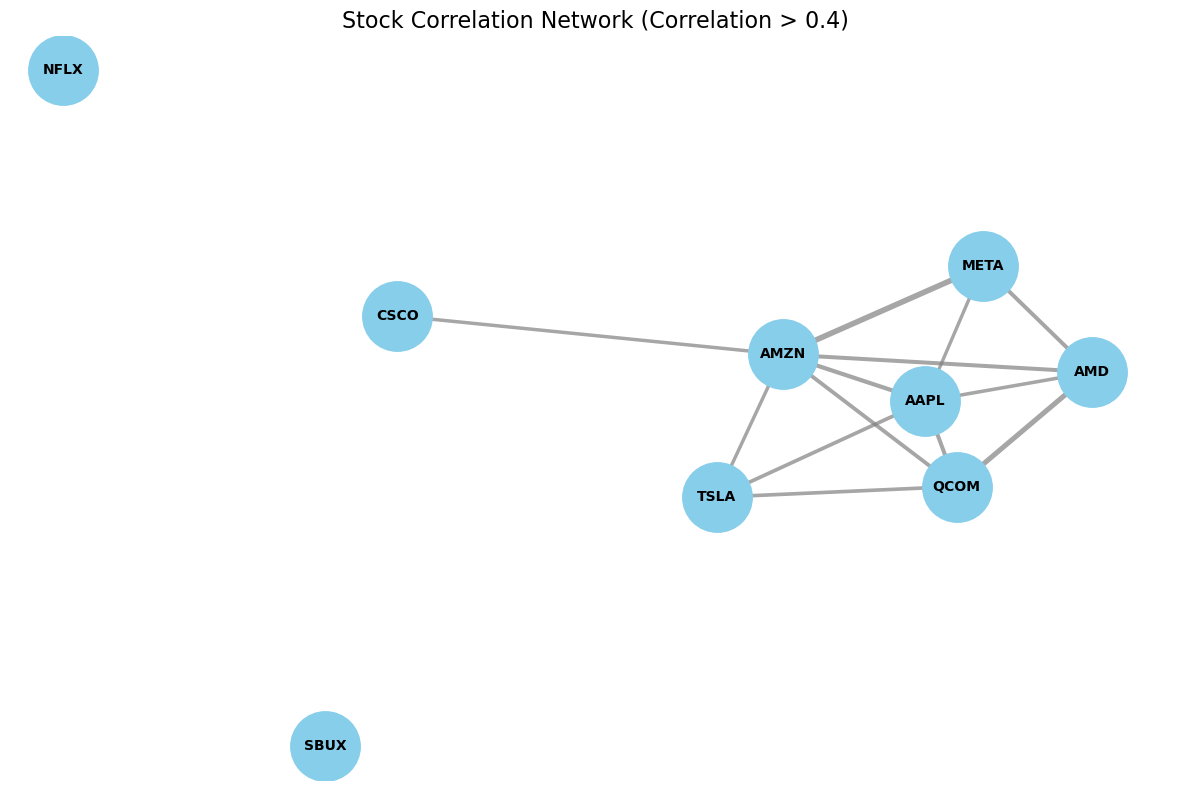

In [4]:
# Create an empty graph
G = nx.Graph()

# Add a node for each stock
for stock in correlation_matrix.columns:
    G.add_node(stock)

# Set a correlation threshold for creating an edge
threshold = 0.4

# Add edges between stocks with correlation above the threshold
for i in correlation_matrix.columns:
    for j in correlation_matrix.columns:
        if i != j and abs(correlation_matrix.loc[i, j]) > threshold:
            G.add_edge(i, j, weight=correlation_matrix.loc[i, j])

# --- Plotting the Network ---
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.6) # k adjusts the distance between nodes

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='skyblue')

# Style and draw the edges
edges = G.edges(data=True)
# Scale edge width by the absolute correlation value for better visualization
weights = [abs(data['weight']) * 6 for _, _, data in edges]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7, edge_color='gray')

# Add labels to the nodes
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_weight="bold")

plt.title(f"Stock Correlation Network (Correlation > {threshold})", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()